# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

nsaves_counter = 0
diagran_counter = 0
def title_num(stitle):
    global diagran_counter
    diagran_counter += 1
    return ("Диаграмма " + str(diagran_counter) + ". " + stitle)


In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import linear_model


## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"

    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False, record_loss=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.record_loss = record_loss
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return (1 / (1 + 1 / np.exp(X @ weights)))

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        matrix = [row @ weights[1:] + weights[0] for row in x]

        return np.sum((np.log(1 + 1 / np.exp(matrix * y)).mean())) + (1 / (2 * self.C)) * weights.T @ weights
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        if hasattr(self, 'weights_'):
            return (self.predict_proba(X) > 0.5) * 2 - 1
        else:
            raise NotFittedError('CustomLogisticRegression instance is not fitted yet')

    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold,
                                                      size=num_features) # random weight initialization
        if self.record_loss:
            self.loss_history = []
        for i in range(self.max_iter):
            # Переделал с циклов на матричные операции numpy.
            # ... циклом было бы читабельнее,
            # но так работает в разы (!) быстрее.
            matrix1 = (X_ext.T * y).T
            matrix2 = [(1 - (1 / (1 + np.exp(-(row @ self.weights_))))) for row in matrix1]
            matrix3 = (matrix1.T * matrix2).T
            delta = -np.sum(np.array(matrix3), axis=0) / X_ext.shape[0] + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            w_t = self.weights_ + self.eta * delta
            
            if (np.linalg.norm(w_t - self.weights_) < self.tol):
                break

            if self.record_loss:
                self.loss_history.append([i + 1, self.get_loss(X, self.weights_, y)])


*****
### `КОММЕНТАРИЙ`

>Выше, в описании класса `CustomLogisticRegression` в методе fit(), были использованы матричные операции. Использование матричных операций оптимизировано на уровне библиотеки numpy за счёт вставок кода на `C`, который, естественно, выполняется быстрее. 
>
>Сравнение показало, что замена обработки циклом на матричные операции numpy сократила время выполнения почти в три раза.
*****


In [6]:
from sklearn import datasets
from sklearn import metrics

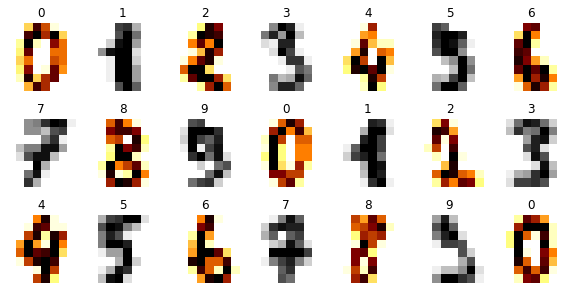

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression(max_iter=1000)

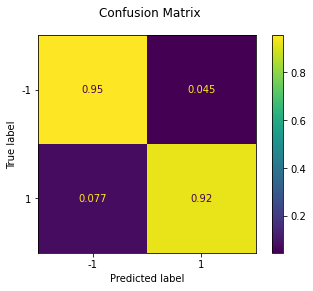

Время выполнения: 00:08


In [15]:
import time
start_prog_time = time.time()

train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test);

duration_in_seconds = int(time.time() - start_prog_time)
print("Время выполнения: {0:0>2}:{1:0>2}".format(duration_in_seconds // 60, duration_in_seconds % 60))

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [18]:
def drow_line_plot1(tol=0.00001, zero_init=False):
    max_iter=10000
    start_prog_time = time.time()

    model = CustomLogisticRegression(max_iter=max_iter, tol=tol, zero_init=zero_init, record_loss=True)
    model.fit(X_train, y_train)
    model.loss_history

    plt.figure(figsize=(16, 8))
    sns.lineplot(x=np.array(model.loss_history)[:, 0], y=np.array(model.loss_history)[:, 1])

    plt.xlabel('Количество сделанных итераций')
    plt.ylabel('Ошибка (loss)')
    plt.grid(True)
    plt.title(title_num("Зависимость ошибки от количества выполненных операций"), fontsize=15)

    plt.show()
    if zero_init:
        print(f"Исходные коэффициенты иницированы нулями!\n")
    else:
        print(f"Исходные коэффициенты иницированы слцчайными значениями!\n")
        
    print(f"Последняя итерация для tol={tol} будет: {len(model.loss_history)}")
    print(f"Значение критерия оптимизации (loss): {model.loss_history[len(model.loss_history)-1][1]}")
    duration_in_seconds = int(time.time() - start_prog_time)
    print("Время выполнения: {0:0>2}:{1:0>2}".format(duration_in_seconds // 60, duration_in_seconds % 60))

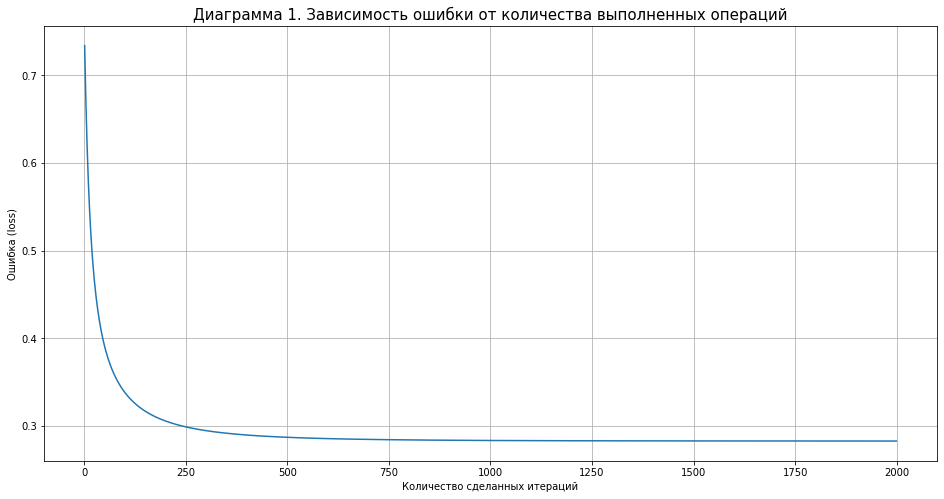

Исходные коэффициенты иницированы слцчайными значениями!

Последняя итерация для tol=1e-05 будет: 1999
Значение критерия оптимизации (loss): 0.28246420337156664
Время выполнения: 00:27


In [19]:
drow_line_plot1()

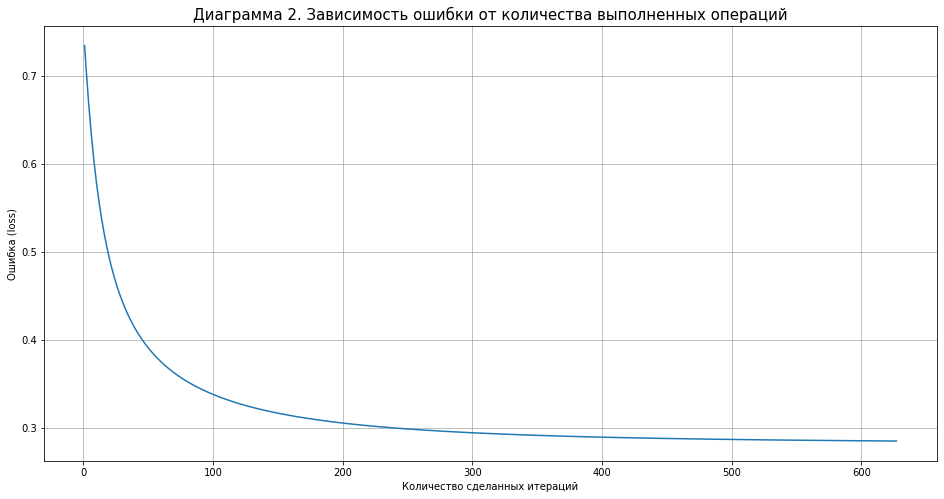

Исходные коэффициенты иницированы слцчайными значениями!

Последняя итерация для tol=0.0001 будет: 627
Значение критерия оптимизации (loss): 0.28492541919124265
Время выполнения: 00:07


In [20]:
drow_line_plot1(tol=0.0001)

*****
### `КОММЕНТАРИЙ`

>Наглядно видно что `CustomLogisticRegression` с ростом числа итераций сокращает ошибку, что отражает рыботу градиентного спуска.
>
>Можно отметить, что:
>* визуально динамика уменьшения ошибки стремится к нуля и уже после 600 итераций уже почти не заметна;
>* регулируя чувствствительность к остановке (tol) можно контролировать длительность подбора параметров исключая таким образом малопроизводительные итерации в случаях когда динамика ошибки становится малозначительной для задачи (для tol=0.00001 останов произошёл на 1999 итерации, а при tol=0.0001 на 627, **сократив время работы алгоритма в три раза при малозначительном отличии ошибки**).
>
Для дальнейших исстедований будем использовать:
* `tol=0.0001`.
* `max_iter = 1000`

*****


**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [21]:
def drow_line_plot2(eta=0.001):
    tol = 0.0001
    max_iter = 1000
    start_prog_time = time.time()

    model = CustomLogisticRegression(eta=eta, max_iter=max_iter, tol=tol, record_loss=True)
    model.fit(X_train, y_train)
    model.loss_history

    plt.figure(figsize=(16, 8))
    sns.lineplot(x=np.array(model.loss_history)[:, 0], y=np.array(model.loss_history)[:, 1])

    plt.xlabel('Количество сделанных итераций')
    plt.ylabel('Ошибка (loss)')
    plt.grid(True)
    plt.title(title_num("Определение влияния параметра скорости обучения"), fontsize=15)

    plt.show()
    print(f"Задано итераций не более: {max_iter}\nПоследняя итерация для eta={eta} будет: {len(model.loss_history)}")
    print(f"Значение критерия оптимизации (loss): {model.loss_history[len(model.loss_history)-1][1]}")
    duration_in_seconds = int(time.time() - start_prog_time)
    print("Время выполнения: {0:0>2}:{1:0>2}".format(duration_in_seconds // 60, duration_in_seconds % 60))

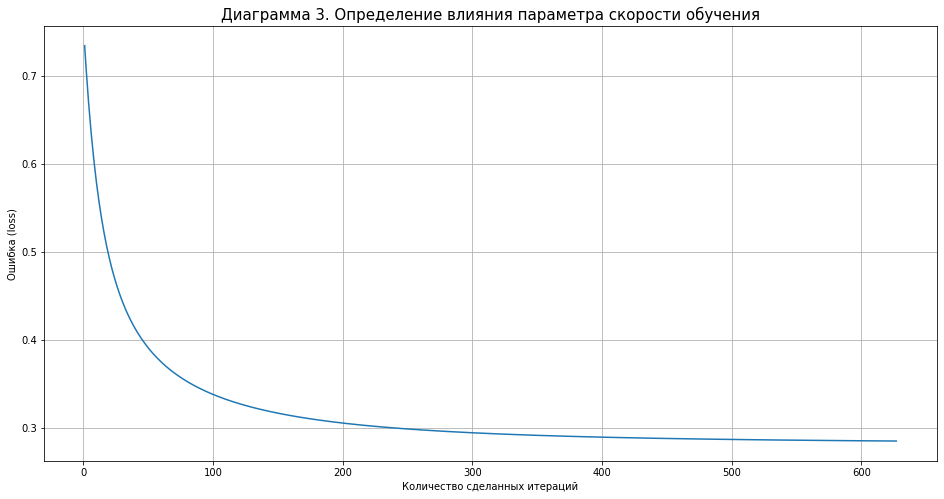

Задано итераций не более: 1000
Последняя итерация для eta=0.001 будет: 627
Значение критерия оптимизации (loss): 0.28492541919124265
Время выполнения: 00:07


In [22]:
drow_line_plot2(eta=0.001)

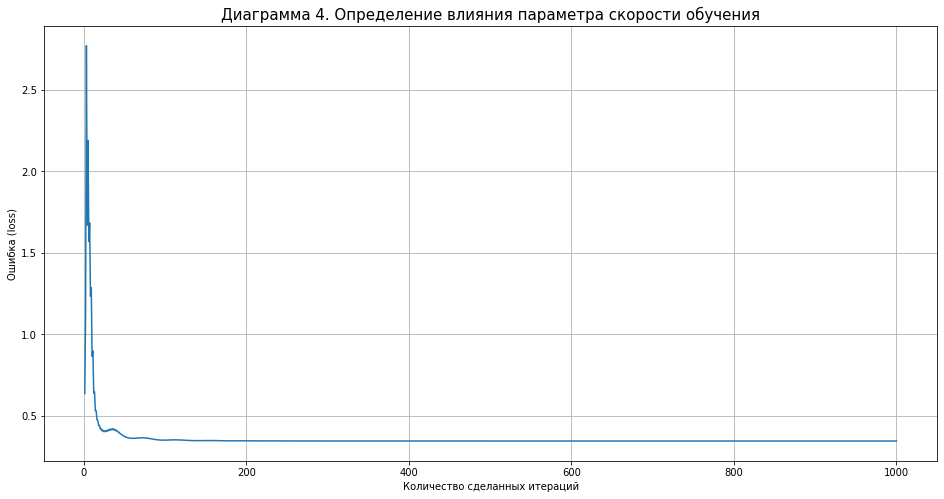

Задано итераций не более: 1000
Последняя итерация для eta=0.008 будет: 1000
Значение критерия оптимизации (loss): 0.344591762598501
Время выполнения: 00:11


In [23]:
drow_line_plot2(eta=0.008)

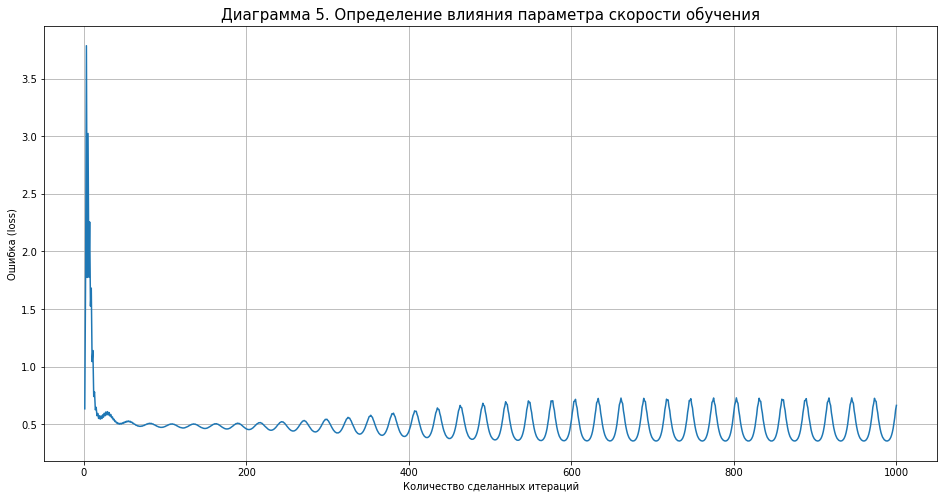

Задано итераций не более: 1000
Последняя итерация для eta=0.01 будет: 1000
Значение критерия оптимизации (loss): 0.6643146399865273
Время выполнения: 00:13


In [24]:
drow_line_plot2(eta=0.01)

*****
### `КОММЕНТАРИЙ`

>Наглядно видно что в нашей реализации `CustomLogisticRegression` с увеличение eta, ответственного за learning rate, визуально ведёт себя по разному.
>
>Учитывая то, что критерия остановки (параметр tol) установлен равным 0.0001, мы можем наблюдать, что параметр eta установленный в значение равное:
>* 0.001 позволяет достигнуть за 627 итерации оптимального значения и остановиться за счет критерия оставновки;
>* 0.008 уже заставляет градиентный спуск "дёргаться" при старте подбора параметров, в последствии выравниваясь, но на 1000-ой итераций так не успев подобрать оптимальные параметры (в предыдущем случае результат лучше, не смотря на меньшее количество итераций);
>* 0.01 уже визуально позволяет увидеть, как идёт "блуждание" градиентного спуска в поисках оптимального значения, которое не получается достигнуть из-за излишнего (грубого) значения eta - итоговый результат ещё хуже.


Для дальнейших исстедований будем использовать:
* `tol=0.0001`.
* `max_iter = 1000`
* `eta=0.001`

*****


**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [25]:
def drow_line_plot3(С=1.0, eta=0.001):
    tol = 0.0001
    max_iter = 1000
    start_prog_time = time.time()

    model = CustomLogisticRegression(eta=eta, max_iter=max_iter, tol=tol, record_loss=True)
    model.fit(X_train, y_train)
    model.loss_history

    plt.figure(figsize=(16, 8))
    sns.lineplot(x=np.array(model.loss_history)[:, 0], y=np.array(model.loss_history)[:, 1])

    plt.xlabel('Количество сделанных итераций')
    plt.ylabel('Ошибка (loss)')
    plt.grid(True)
    plt.title(title_num("Определение влияния параметра регуляризации"), fontsize=15)

    plt.show()
    print(f"Задано итераций не более: {max_iter}")
    print(f"Прамаетр ответственный за скорость обучения eta={eta}")
    print(f"Параметр регуляризации С={С}")
    print(f"Останов произошёл на итерации: {len(model.loss_history)}")
    print(f"Значение критерия оптимизации (loss): {model.loss_history[len(model.loss_history)-1][1]}")
    
    duration_in_seconds = int(time.time() - start_prog_time)
    print("Время выполнения: {0:0>2}:{1:0>2}".format(duration_in_seconds // 60, duration_in_seconds % 60))

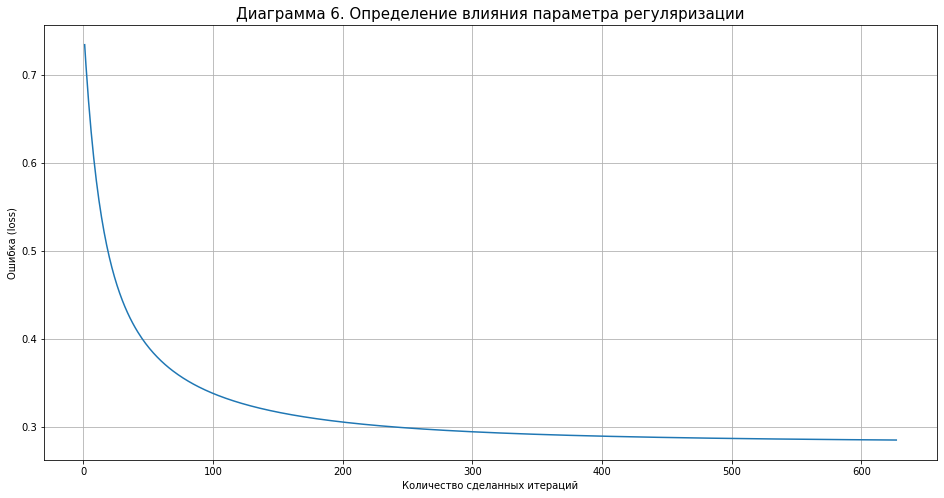

Задано итераций не более: 1000
Прамаетр ответственный за скорость обучения eta=0.001
Параметр регуляризации С=2.0
Останов произошёл на итерации: 627
Значение критерия оптимизации (loss): 0.28492541919124265
Время выполнения: 00:09


In [26]:
drow_line_plot3(С=2.0)

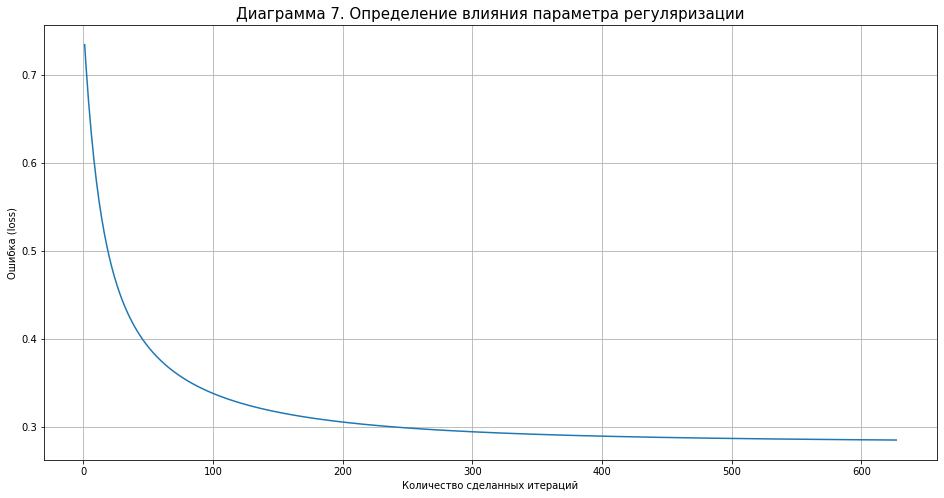

Задано итераций не более: 1000
Прамаетр ответственный за скорость обучения eta=0.001
Параметр регуляризации С=10.0
Останов произошёл на итерации: 627
Значение критерия оптимизации (loss): 0.28492541919124265
Время выполнения: 00:07


In [27]:
drow_line_plot3(С=10.0)

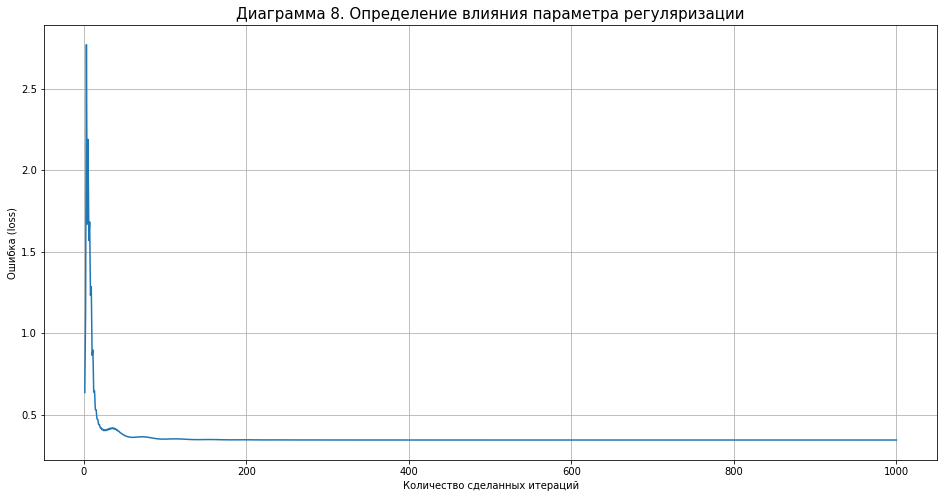

Задано итераций не более: 1000
Прамаетр ответственный за скорость обучения eta=0.008
Параметр регуляризации С=0.0001
Останов произошёл на итерации: 1000
Значение критерия оптимизации (loss): 0.344591762598501
Время выполнения: 00:12


In [28]:
drow_line_plot3(С=0.0001, eta=0.008)

*****
### `КОММЕНТАРИЙ`

> **Ничего не увидел...**
*****


**(0.5 points)** Compare zero initialization and random initialization. 

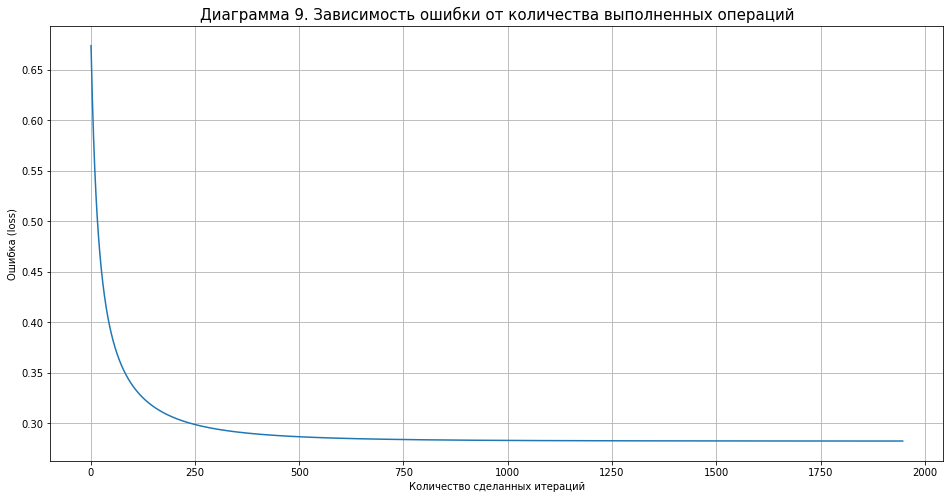

Исходные коэффициенты иницированы нулями!

Последняя итерация для tol=1e-05 будет: 1947
Значение критерия оптимизации (loss): 0.28246228844251736
Время выполнения: 00:24


In [29]:
drow_line_plot1(zero_init=True)

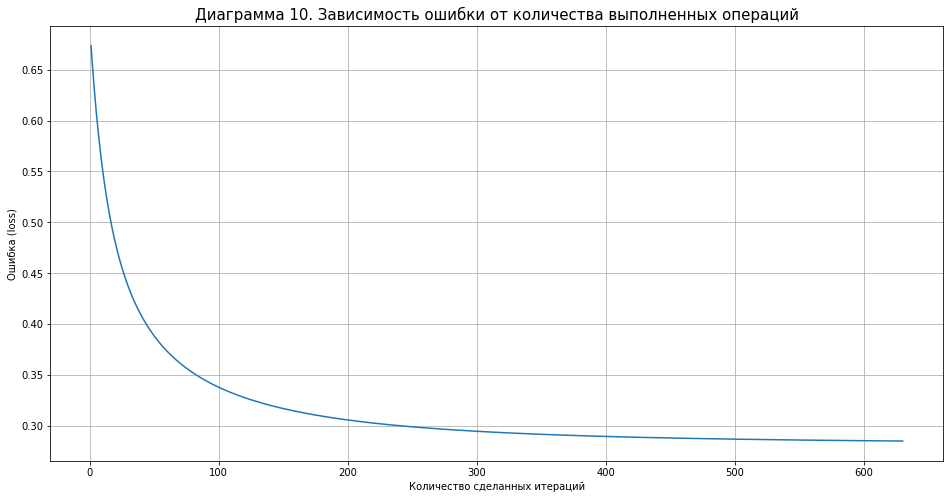

Исходные коэффициенты иницированы нулями!

Последняя итерация для tol=0.0001 будет: 630
Значение критерия оптимизации (loss): 0.284856147861374
Время выполнения: 00:07


In [30]:
drow_line_plot1(tol=0.0001, zero_init=True)

*****
### `КОММЕНТАРИЙ`

>Две последние диаграммы дублируют диаграммы №1 и №2 с одним отличием: здесь параметры иницированы нулевыми значениями, а в первых двух - случайными.
>
>Можем наблюдать небольшие отличия - изменилось количество итераций. Это связано с тем, что нулевые значения оказались в одном случае ближе, а в другом дальше локального минимум, к которому стремится алгоритм градиентного спуска.
>
>Это единственное отличие, которое мы наблюдаем. Начальное зануление параметров не влияет негативно на способность градиентного спуска двигаться в сторону локального минимума, так как производная минимизируемой функции не равна нулю (нулевое значение создат некотороые сложности, так как в этом случае не пронятен способ выбора направления движения).
*****


## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

*****
### `КОММЕНТАРИЙ`

>Для расчета попарного евклидова расстояния между двумя группами веткоров можно воспользоваться библиотечной функцией `scipy.spatial.distance_matrix` или "извратиться" и реализовать её самостоятельно. Оба варианта рабочие и представлены ниже. При желании можно закоментировать одну и раскомментировать другую.
*****


In [31]:
from scipy.spatial import distance_matrix

# def distance_matrix(A, B, squared=False):
#     # https://www.dabblingbadger.com/blog/2020/2/27/implementing-euclidean-distance-matrix-calculations-from-scratch-in-python
    
#     M = A.shape[0]
#     N = B.shape[0]

#     A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
#     B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
#     D_squared =  A_dots + B_dots -2*A.dot(B.T)

#     if squared == False:
#         zero_mask = np.less(D_squared, 0.0)
#         D_squared[zero_mask] = 0.0
#         return np.sqrt(D_squared)

#     return D_squared

# distance_matrix(X_data, Y_data)

In [32]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return(distance_matrix(X, Y))
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        
        # <your code>
        if not hasattr(self, 'classes_'):
            raise NotFittedError("get_class_weights: CustomKNeighborsClassifier instance is not fitted yet")
            return
        
        # weights - перечень пришедших весов
        # y - перечень классов для пришедших весов
        # Вычисли суммы по классам:
        classes_sum = pd.DataFrame({"data": weights, "index": y}).groupby(by="index").sum().fillna(0)
        # Установим правильный порядок, в соответствии
        # с очерёдностью классов в self.classes_
        ret_value = pd.DataFrame(classes_sum, self.classes_).to_numpy()[:,0]
        # Уберём nan, так как если в пришедлем списке
        # не было чего-то из self.classes_, то они будут nan
        ret_value[np.isnan(ret_value)] = 0
        return(ret_value)
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if not hasattr(self, 'points'):
            raise NotFittedError("predict_proba: CustomKNeighborsClassifier instance is not fitted yet")
        else:
            P = self.get_pairwise_distances(self.points, X)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
            else: # то есть 'uniform'
                pass # weights_of_points = np.ones(P.shape)

            # Обрабатывать будем каждую отдельную точку (в цикле, как без цикла пока не знаю)
            ret_value = []
            for idx in range(X.shape[0]):
                distanses_4_one_point = P[:,idx]
                waights_4_one_point = weights_of_points[:,idx]
                # Определяем границу для K-ближаших:
                max_value = sorted(distanses_4_one_point)[self.n_neighbors - 1]
                # Определим маску для тех элементов, которые будем передавать
                # для рассчета суммы весов для классов:
                mask = distanses_4_one_point <= max_value
                classes_weights_in_this_point = self.get_class_weights(self.y[mask], waights_4_one_point[mask])
                proba = classes_weights_in_this_point/classes_weights_in_this_point.sum()
                # Тут не описанная в задании ситуация: без округления не проходит assert
                # пришлось смотреть до какого знака округляет стандартный KNeighborsClassifier
                # и брать значение (7) оттуда. Но не факт, что на других ПК или в других версиях
                # sklearn это значение сохранится
                ret_value.append(np.round(proba, 7))

            return(np.array(ret_value))
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        if hasattr(self, 'points'):
            return ( np.argmax(self.predict_proba(X), axis=1) )
        else:
            raise NotFittedError('predict: CustomLogisticRegression instance is not fitted yet')


In [33]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [34]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [35]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

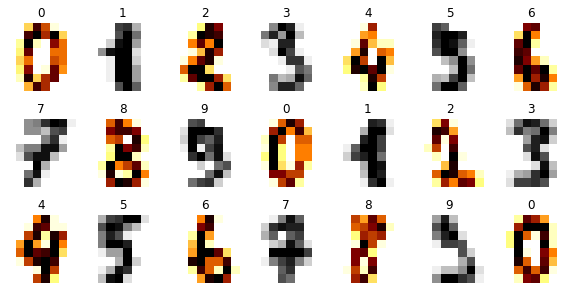

In [36]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [37]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [38]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

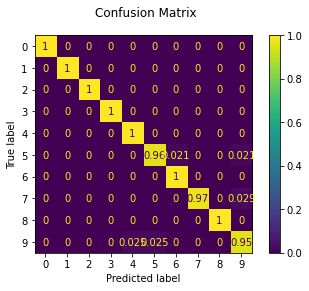

In [39]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [40]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

*****
### `КОММЕНТАРИЙ`

>Мы видим, что все числа были отнесены к правильным классам, но по некоторым из них возникли "сомнения".
Сonfusion matrix фактически отображает то, где построенная модель "путает"/"сомневается" в принадлежности наблюдения (вектора, описывающего число) к тому или иному классу. К таким числа относятся:
>* `5`, которое "путается" с `6` и `9`
>* `7`, которое "путается" с `9`
>
>И действительно, на продемонстрированном выше примере даже визуально эти цифры можно перепутать.
![Альтернативный текст](https://github.com/DIVIGL1/RSSchool-ML-Open-Course/blob/main/numbers.png?raw=true "Путаемые цифры")


>Иных отклонений нет - модель на удивление качественно отработала.
*****


**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

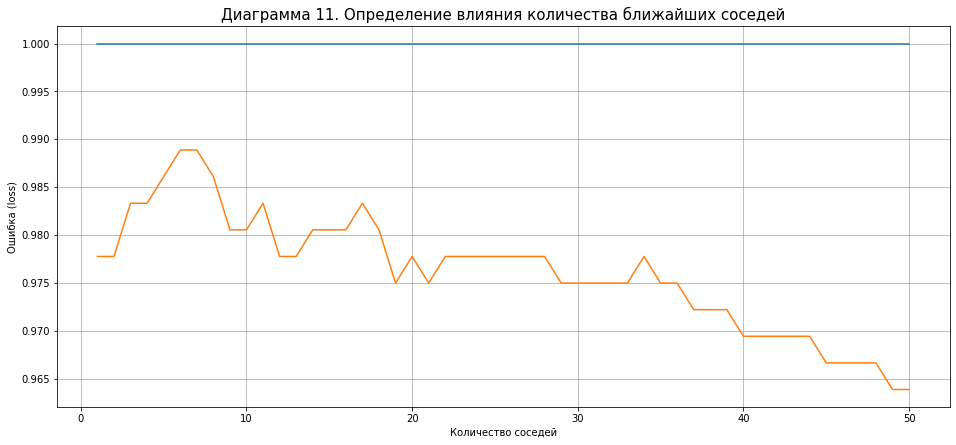

Максимальное значение aсcuraсy равное 0.9888888888888889 достигается на шагах [6 7].

Время выполнения: 06:27


In [41]:
start_prog_time = time.time()

train_acc_list = []
test_acc_list = []

# Обучение модели сводится к копированию данных, поэтому создадим один раз,
# а в цикле будем только менять количество соседей.
model = CustomKNeighborsClassifier(n_neighbors=1, weights='distance')
model.fit(X_train, y_train)

for n_nebors in range(1, 51):
    model.n_neighbors = n_nebors
    
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    train_acc_list.append([n_nebors, train_acc])
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    test_acc_list.append([n_nebors, test_acc])
    
plt.figure(figsize=(16, 7))
sns.lineplot(x=np.array(train_acc_list)[:, 0], y=np.array(train_acc_list)[:, 1])
sns.lineplot(x=np.array(test_acc_list)[:, 0], y=np.array(test_acc_list)[:, 1])

plt.xlabel('Количество соседей')
plt.ylabel('Ошибка (loss)')
plt.grid(True)
plt.title(title_num("Определение влияния количества ближайших соседей"), fontsize=15)

plt.show()

test_acc_list = np.array(test_acc_list)
max_test_acc = test_acc_list[:, 1].max()
max_steps = test_acc_list[:, 0][test_acc_list[:, 1] == max_test_acc]
print(f"Максимальное значение aсcuraсy равное {max_test_acc} достигается на шагах {max_steps.astype(int)}.\n")

duration_in_seconds = int(time.time() - start_prog_time)
print("Время выполнения: {0:0>2}:{1:0>2}".format(duration_in_seconds // 60, duration_in_seconds % 60))

*****
### `КОММЕНТАРИЙ`

>Диаграмма зависимости метрики от выбранного числа ближайших соседей показывает, что метрика улучшается пока число соседей небольшое. Но после какого-то значения она начинает деградировать. Скорее всего причина в том, что из-за бОльшего числа соседей начинают вмешиваться "неправильные" и более далёкие соседи - соседи из других классов и, как следствие, происходит не правильная классификация.
>
>В тоже время, метрика на обучающей выборке вегда равна 1.
*****


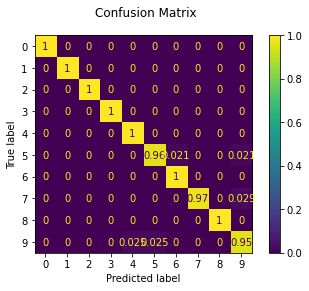

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9861111111111112


In [42]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print("Accuracy на тренировочных данных:", train_acc)
print("Accuracy на тестовых данных:", test_acc)

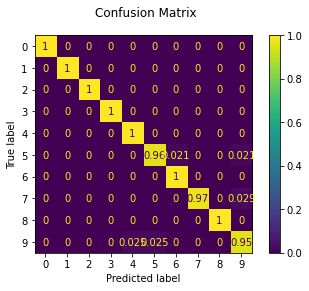

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9861111111111112


In [43]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print("Accuracy на тренировочных данных:", train_acc)
print("Accuracy на тестовых данных:", test_acc)

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

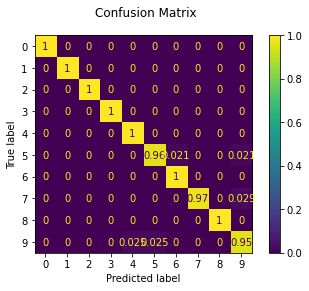

Accuracy на тренировочных данных: 0.9895615866388309
Accuracy на тестовых данных: 0.9861111111111112


In [44]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print("Accuracy на тренировочных данных:", train_acc)
print("Accuracy на тестовых данных:", test_acc)

*****
### `КОММЕНТАРИЙ`

* Полученные данные показывают, что параметр `weights='distance'` более предрасположено к переобучению, так как может больше игнорировать соседей которые находятся дальше.
* В рассматриваемых примерах, используя в качестве метрики `accuracy` нет значительного отичия между данными параметрами
* Полученные значения вероятностей, судф по диаграммам, совпадают.
*****


**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

*****
### `КОММЕНТАРИЙ`

>* Такие меры как квадрат евклидова расстаяния или обобщённое расстояние Миньковского только увеличат влиянием ближайших точек и приведут к ещё большей перебучаемости модели.
>* Линейное расстояние и расстояние Чебышева, видимо будут иметь тот же эффект, что и обычное евклидово расстояние.
>
>В итоге, на вопрос "*Suggest another distance measurement function that could improve the quality of the classification for this task*" *(Предложите другую функцию измерения расстояний, которая могла бы улучшить качество классификации для этой задачи)* у меня нет ответа, который бы только за счёт воздействия на веса повлиял бы на классификацию в лучшую сторону.
*****


**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

*****
### `КОММЕНТАРИЙ`

>* В качестве "бреда" можно рассмотреть следуюшую задачу: определение принадлежности, допустим, точке на глобусе некоторой территории (территория - это класс, множество точек). В этом случае, использовать евклидово расстояние не правильно, так как это расстояние в пространстве, а нам требуется вычилить расстояние на поверхности шара.
>
>* Другой пример: текст. Это совершенно другой объект и расстояние должно иметь совсем другой смысл. Может использоваться, например, расстояние Хэмминга, которое в принципе используется для категориальных параметров.
*****


## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [45]:
PATH = "./data/"

In [46]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [47]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

### `Информация для понимания содержимого столбцов`

>| Столбец       | Описание              | Значения      
|:--------------|:----------------------|:-------------
| **Survived**  | Выжил или нет         | 0=Нет, 1=Да   
| **Pclass**    | Класс билета          | 1st, 2nd, 3rd 
| **Name**      | Имя пассажира         |               
| **Sex**       | пол                   | male, female  
| **Age**       | Возраст               | в годах       
| **SibSp**     | братья + мужья и жены |               
| **Parch**     | Родители + дети       |               
| **Ticket**    | Номер билета          |               
| **Fare**      | Плата за проезд       |               
| **Cabin**     | Номер каюты           |               
| **Embarked**  | Порт посадки на борт  | C = Cherbourg  
|               |                       | Q = Queenstown
|               |                       | S = Southampton 
>
>**Примечания к переменным**
>
>**pclass**: Доступность для социально-экономического статуса (SES)
>	1st = Upper
>	2nd = Middle
>	3rd = Lower
>
>**age**: Возраст является дробным, если он меньше 1. Если же возраст дольше 1, то он в виде xx.5 (с точностью до полугода)
>
>**sibsp**: Набор данных определяющий следующие семейные отношения (горизонтальные):
>	Sibling = брат, сестра, сводный брат, сводная сестра
>	Spouse = муж, жена (любовницы и женихи игнорировались)
>
>**parch**: Набор данных определяющий следующие семейные отношения (вертикальные):
>	Parent = отец, мать
>	Child = дети: дочь, сын, падчерица, пасынок
>(Некоторые дети путешествовали только с няней, поэтому для них parch=0)

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [48]:
data.shape

(100000, 11)

In [49]:
data["Sex"].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [50]:
data.Survived.value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

In [51]:
data["Survived"].value_counts()[0]

57226

In [52]:
print(f"Процент выживших равен: {100 * data.Survived.value_counts()[1] / data.shape[0]}")

Процент выживших равен: 42.774


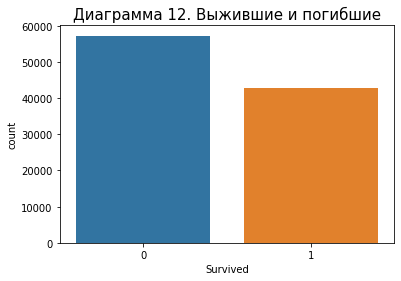

In [53]:
sns.countplot(x="Survived",data=data)
plt.title(title_num("Выжившие и погибшие"), fontsize=15);

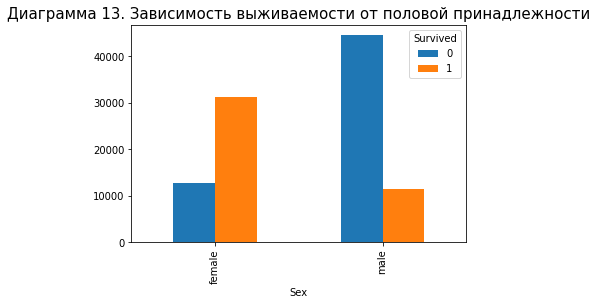

In [54]:
df_help = data.groupby(['Sex', 'Survived'])['Sex'].count().unstack('Survived')
df_help.plot(kind='bar')
plt.title(title_num("Зависимость выживаемости от половой принадлежности"), fontsize=15);

*****
### `ИТОГИ`

>В датасете:
>* мужчин: 56'114
>* женщин: 43'886
>* **ВСЕГО 100'000 человек.**
>
>
>* Погибло 57'226 человек.
>* Выживших 42.774%
>
>
>* Женщин спаслось как в абсолютном, так и в относительном выражении больше чем мужчин.
*****


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [55]:
data["Age"].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

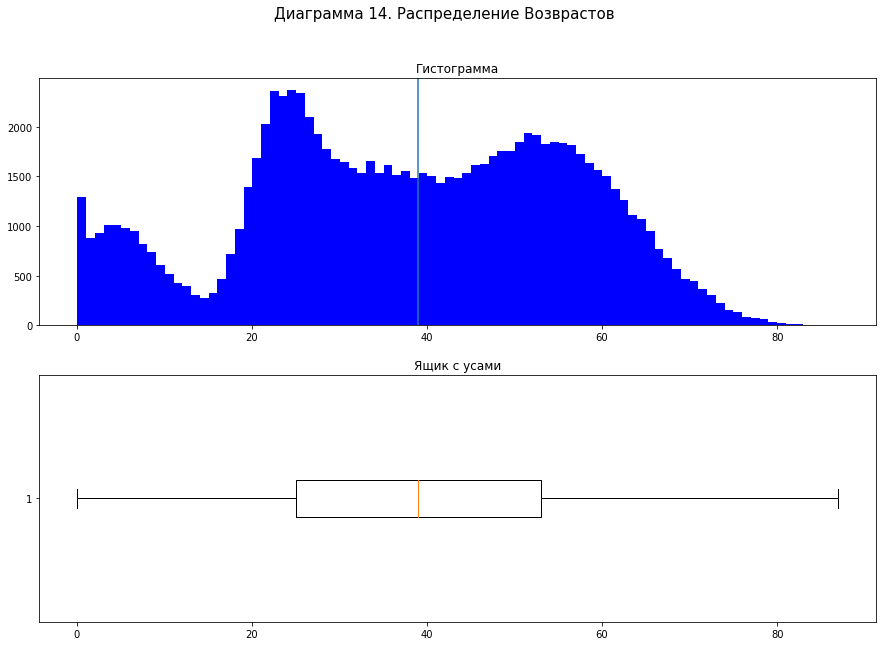

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
df_for_age = data[data.Age.isna()==False]

ax1.hist(df_for_age.Age, bins=87, color='blue')
ax1.set_title('Гистограмма')
ax1.axvline(df_for_age.Age.median())
ax2.boxplot(df_for_age.Age, vert=False)
ax2.set_title('Ящик с усами')

fig.suptitle(title_num("Распределение Возврастов"), fontsize=15);

In [57]:
# Выделим возрасные группы
def age_type(nage, ntype=1):
    if nage == np.nan:
        retrn ("" if ntype==1 else 0)
    ret_value = ""
    for num, element in enumerate(age_types):
        if (nage > element[1]) & (nage <= element[2]):
            return element[0] if ntype == 1 else num+1

age_types = [
    ["1. Новорождённые", -1, 1], 
    ["2. Дошкольники", 1, 7], 
    ["3. Младшие школьники", 7, 12], 
    ["4. Тинейджеры", 12, 15],
    ["5. Молодые люди", 15, 28],
    ["6. Взрослые люди", 28, 40],
    ["7. Люди от 40 до 60", 40, 60],
    ["8. Пожилые", 60, 200],
           ]

df_help = data.copy()
df_help["age_type"] = df_help["Age"].apply(lambda y: age_type(y))
df_help["age_ntype"] = df_help["Age"].apply(lambda y: age_type(y, 2))
ports_dict = {"C": 1, "Q": 2, "S": 3, np.nan: 0}
sex_dict = {"male": 1, "female": 2, np.nan: 0}
class_dict = {1: "1 класс", 2: "2 класс", 3: "3 класс", np.nan: 0}
df_help["nPort"] = df_help["Embarked"].apply(lambda p: ports_dict[p])
df_help["nSex"] = df_help["Sex"].apply(lambda p: sex_dict[p])
df_help["sPclass"] = df_help["Pclass"].apply(lambda p: class_dict[p])

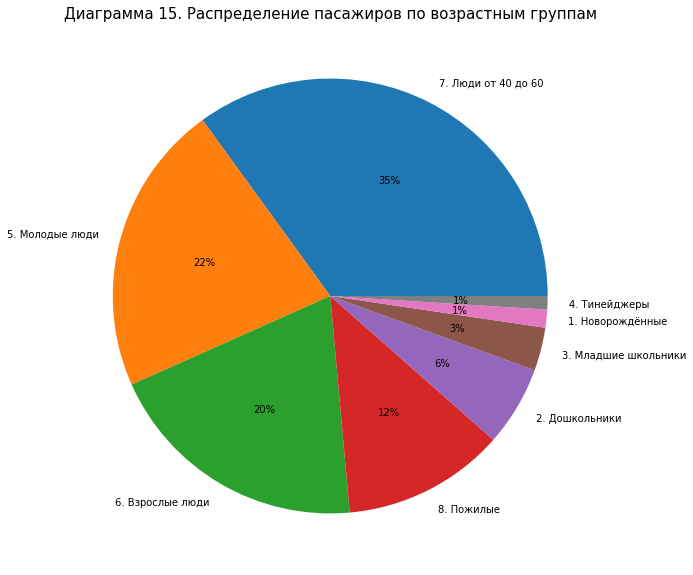

In [58]:
fig = plt.figure(figsize=(10, 10))
plt.title(title_num("Распределение пасажиров по возрастным группам"), fontsize=15)
plt.pie(df_help.age_type.value_counts(), labels=df_help.age_type.value_counts().index.to_list(), autopct='%.0f%%');


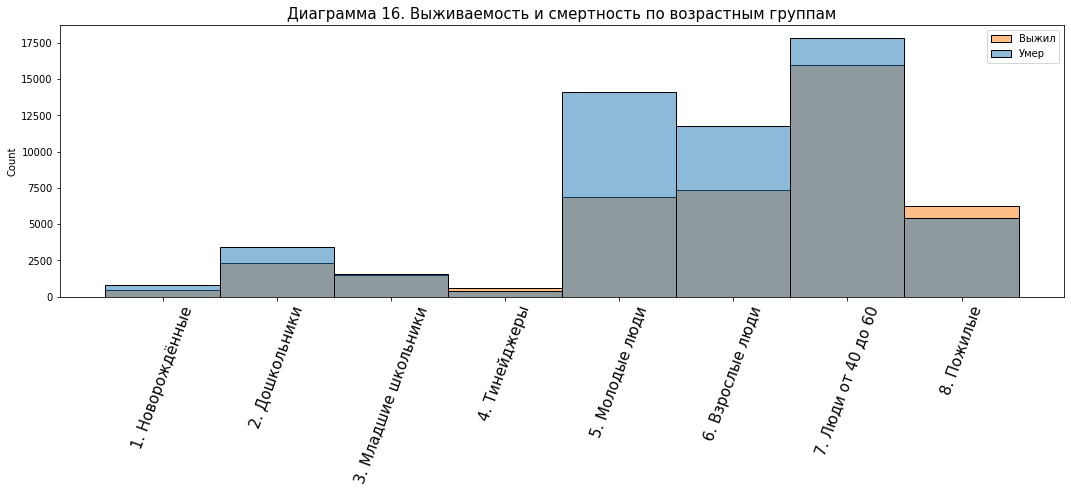

In [59]:
df_sorted = df_help.sort_values(by="age_type")

plt.figure(figsize=(18,5))

sns.histplot(data=df_sorted, x=df_sorted["age_type"], hue=df_sorted["Survived"])
plt.xlabel('')
plt.xticks(rotation=70, fontsize=15)
plt.legend(['Выжил', 'Умер'], title='')
plt.title(title_num("Выживаемость и смертность по возрастным группам"), fontsize=15);


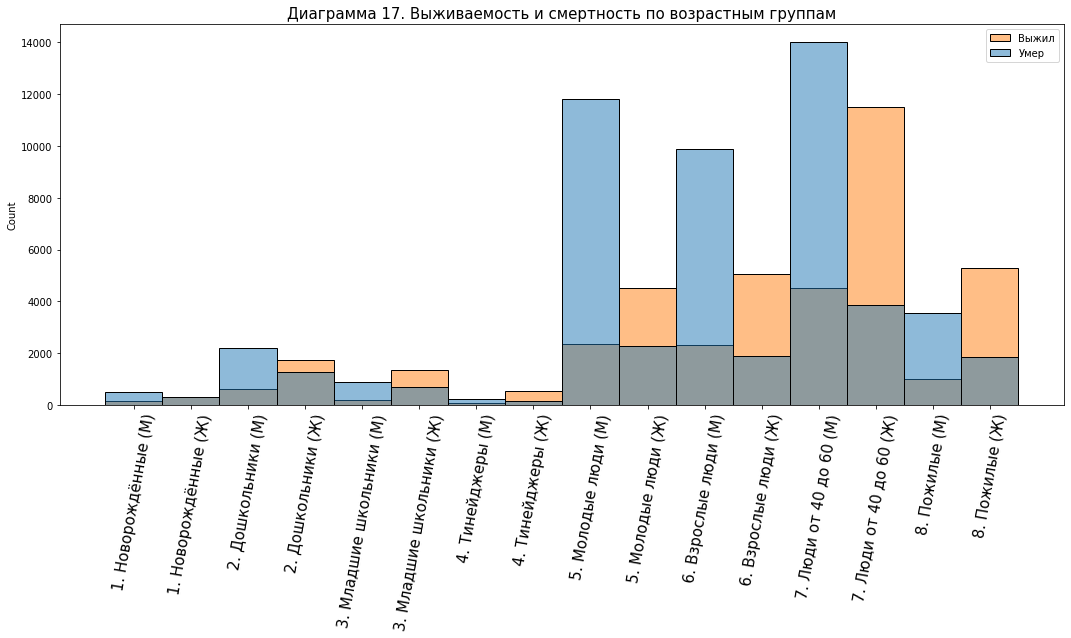

In [60]:
def add_name(data):
    try:
        return data[0] + (" (М)" if data[1] == 1 else " (Ж)")
    except:
        pass

plt.figure(figsize=(18,7))

df_sorted["age_type_sex"] = df_sorted[["age_type", "nSex"]].apply(lambda rowdata: add_name(rowdata.values), axis=1)

df_sorted = df_sorted.sort_values(by=["age_type", "nSex"])
sns.histplot(data=df_sorted, x=df_sorted["age_type_sex"], hue=df_sorted["Survived"]);
plt.xlabel('')
plt.xticks(rotation=80, fontsize=15)
plt.legend(['Выжил', 'Умер'], title='')
plt.title(title_num("Выживаемость и смертность по возрастным группам"), fontsize=15);

*****
### `ИТОГИ`
>
>В датасете:
>* Минимальный возраст меньше одного года.
>* Максимальный возраст 87 лет
>* Среднее значение возраста находится в диапазоне 38 и 39 лет.
>* Медиана между 18 и 19.
>
>Выживаемость по возрастным группам:
>* Найдено две возрастные группы где выживших оказалось больше чем погибших - тинейджеры и пожилые люди.
>* Во всех остальных возрасных группах число умерших больше чем выживших.
>* Нет ни одной возрасной группы по мужчинам где выживших было бы больше чем погибших.
>* Во всех возрасных группвх по женщих выжило больше чем погибло.
>
>Скорее всего, всё это объясняется с тем, что:
>* Спасали в первую очередь женщин.
>* Спасали стариков и тех детей, которые могли выжить самостоятелно (тинейждеры).
>
*****


**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

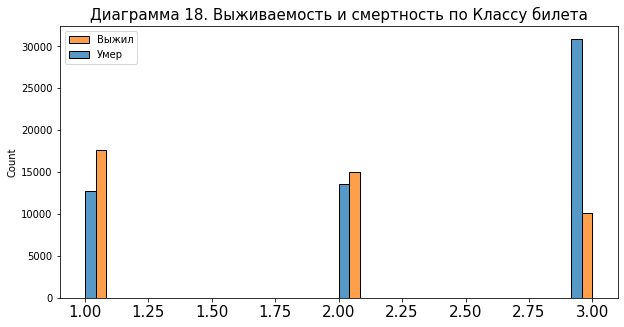

In [61]:
plt.figure(figsize=(10,5))
df_sorted = df_sorted.sort_values(by=["Pclass"])
sns.histplot(data=df_sorted, x=df_sorted["Pclass"], hue=df_sorted["Survived"], multiple="dodge");
plt.xlabel('')
plt.xticks(fontsize=15)
plt.legend(['Выжил', 'Умер'], title='')
plt.title(title_num("Выживаемость и смертность по Классу билета"), fontsize=15);


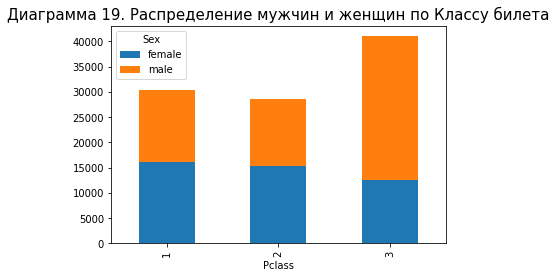

In [62]:
df_help = data.groupby(['Pclass', 'Sex'])['Pclass'].count().unstack('Sex')
df_help.plot(kind='bar', stacked=True)
plt.title(title_num("Распределение мужчин и женщин по Классу билета"), fontsize=15);

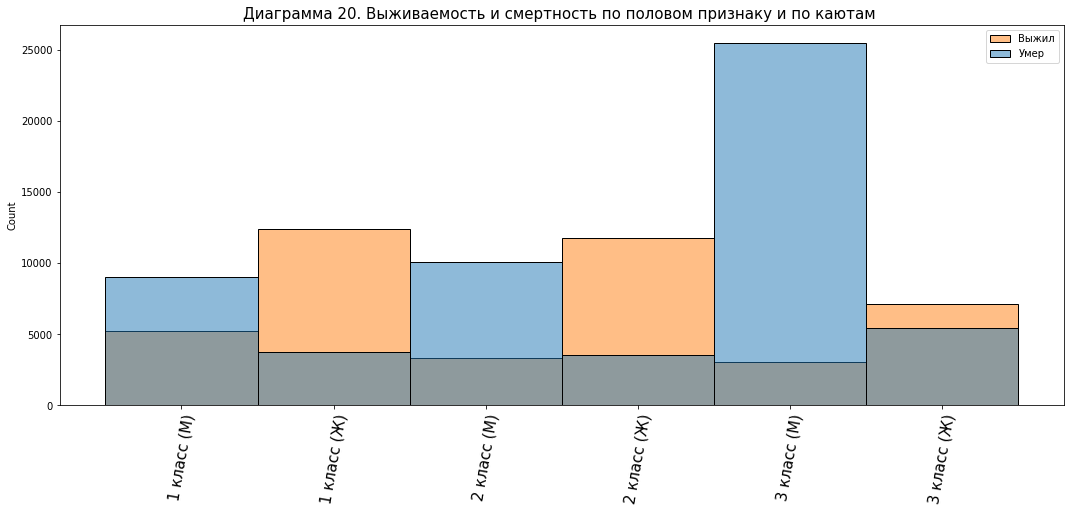

In [63]:
def add_name(data):
    try:
        return data[0] + (" (М)" if data[1] == 1 else " (Ж)")
    except:
        pass

plt.figure(figsize=(18,7))

df_sorted["Pclass_type_sex"] = df_sorted[["sPclass", "nSex"]].apply(lambda rowdata: add_name(rowdata.values), axis=1)

df_sorted = df_sorted.sort_values(by=["sPclass", "nSex"])
sns.histplot(data=df_sorted, x=df_sorted["Pclass_type_sex"], hue=df_sorted["Survived"]);
plt.xlabel('')
plt.xticks(rotation=80, fontsize=15)
plt.legend(['Выжил', 'Умер'], title='')
plt.title(title_num("Выживаемость и смертность по половом признаку и по каютам "), fontsize=15);

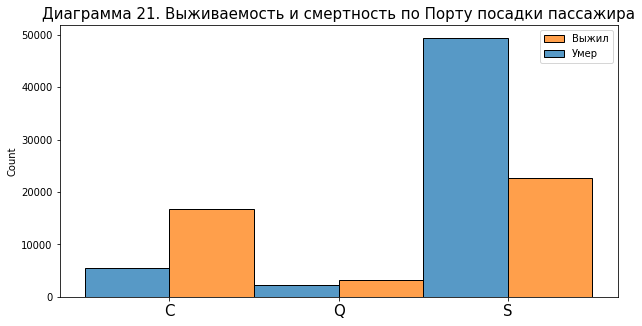

In [64]:
plt.figure(figsize=(10,5))
df_sorted = df_sorted.sort_values(by=["Embarked"])
sns.histplot(data=df_sorted, x=df_sorted["Embarked"], hue=df_sorted["Survived"], multiple="dodge");
plt.xlabel('')
plt.xticks(fontsize=15)
plt.legend(['Выжил', 'Умер'], title='')
plt.title(title_num("Выживаемость и смертность по Порту посадки пассажира"), fontsize=15);



*****
### `ИТОГИ`
>
>По имеющимся данным видим:
>* Самая высокая выживаемость оказалась у пассажиров размещнных в 1-м классе.
>* В относительном выражении больше выживали пассажиры, чья посадка совершалась в Cherbourg, далее Queenstown и основная доля погибших была из Southampton.
>* Так же как и ранее мужчин выживает меньше чем спасается, но основаня часть погибших мужчин - это мужчины из 3-го класса.
>
*****


### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

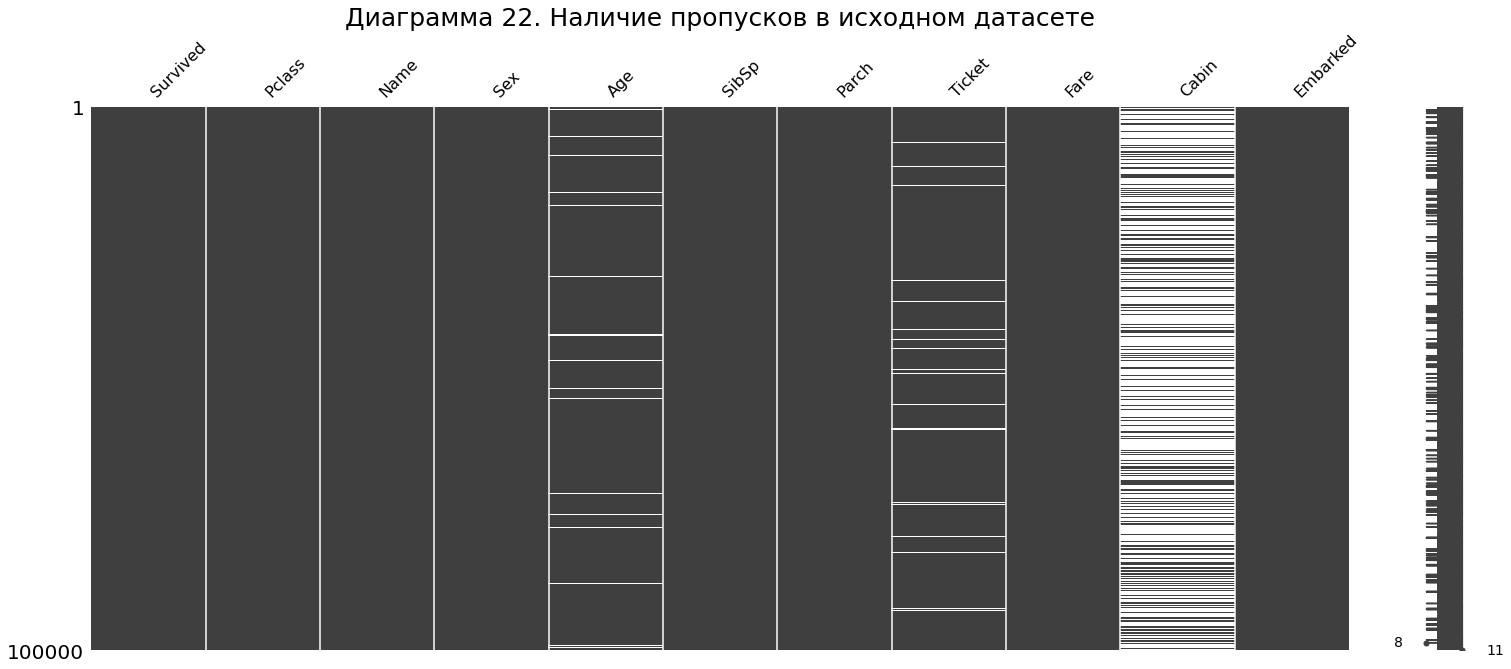

In [65]:
msno.matrix(data)
plt.title(title_num("Наличие пропусков в исходном датасете"), fontsize=25);


In [66]:
df_start_shape = data.shape
print(df_start_shape)

(100000, 11)


In [67]:
# Посмотрим проценты пропусков в данных по столбцам:
missing_values = ((data.isna().sum() / df_start_shape[0]) * 100 ).sort_values(ascending=False)
print("-------------------------------")
print("Процент пропущенных значений:")
print(missing_values)
print("-------------------------------")
missing_values = data.isna().sum().sort_values(ascending=False)
print("Количество пропущенных значений:")
print(missing_values)
print("-------------------------------")


-------------------------------
Процент пропущенных значений:
Cabin       67.866
Ticket       4.623
Age          3.292
Embarked     0.250
Fare         0.134
Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
SibSp        0.000
Parch        0.000
dtype: float64
-------------------------------
Количество пропущенных значений:
Cabin       67866
Ticket       4623
Age          3292
Embarked      250
Fare          134
Survived        0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
dtype: int64
-------------------------------


### Немного остановимся на номерах билетов и каютах.


In [68]:
data[data["Cabin"]=="C6906"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
13492,0,1,"Fogle, Timmy",male,26.0,0,0,27731,28.32,C6906,S
24017,1,1,"Croft, Caroline",female,59.0,0,3,30035,15.26,C6906,Q
39887,1,1,"Funston, Valentina",female,40.0,0,0,SOTON/OQ 23895,35.32,C6906,S
61909,0,3,"Washington, Jorge",male,61.0,0,2,23555,26.60,C6906,S
94462,1,1,"Landreth, Lorraine",female,47.0,0,0,33544,139.45,C6906,S


*****
### `КОММЕНТАРИЙ`

>Обнаруживаем, что в одной каюте расположились пять человек, разных полов, разных возрастов, севшие в разных портах и что самое странное, с разными колассами билетов и их стоимостью. Тоже самое наблюдаем и со следующей каютой:
*****



In [69]:
data[data["Cabin"]=="C12388"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
18813,0,3,"Ainsworth, Everett",male,40.0,3,0,173339,64.20,C12388,S
23920,0,1,"Lim, Walter",male,49.0,1,3,39334,28.68,C12388,S
61437,1,1,"Guzman, William",male,50.0,0,0,PC 490379,134.57,C12388,S
76006,1,1,"Suh, Darrell",male,55.0,1,2,23986,62.29,C12388,S
84519,1,1,"Brunette, Nolan",male,21.0,0,0,S.C./A.4. 457272,27.93,C12388,C


In [70]:
data["Ticket"].value_counts()[20:]

12198           9
12736           9
10362           8
10867           8
11924           8
               ..
421812          1
PC 420601       1
PC 26800        1
STON/O 23755    1
458074          1
Name: Ticket, Length: 75311, dtype: int64


*****
### `КОММЕНТАРИЙ`
>
>Нечто подобное (как с каютами) наблюдаем и номерами билетов: несколько человек имеют один и тот же номер билета:
*****


In [71]:
data[data["Ticket"] == "12198"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
21184,1,1,"Scarlett, Thomas",male,33.0,0,0,12198,22.46,NaN,S
34981,1,1,"Bryant, Jason",male,30.0,1,2,12198,77.96,B11047,C
36448,0,1,"Nemeth, Jeffrey",male,65.0,1,0,12198,24.21,A22055,C
49883,0,2,"Holder, Steven",male,26.0,0,0,12198,6.56,NaN,S
52023,0,3,"Broom, Boris",male,22.0,0,0,12198,12.22,NaN,S
56230,0,3,"Chowenhill, Donna",female,5.0,1,2,12198,34.02,NaN,S
65236,0,3,"Monroe, Johnathan",male,51.0,0,0,12198,19.15,NaN,S
76556,0,2,"Whitley, Joseph",male,46.0,0,0,12198,25.59,NaN,S
84276,0,3,"Wynn, Angel",male,24.0,0,0,12198,11.28,NaN,S


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?


*****
### `КОММЕНТАРИЙ`
>
>Пустые билеты и каюты можно заполнить соответствующими текстовыми лейблами. Эти строки нельзя, потому что их слишком много. Но предлагается удалить эти столбецы в принципе. Из недостаков можно назвать потенциальную потерю дополнительной информации, но скорее это не так  - выше разобрали неаколько примеров. **Предлагается удалить.**
>
>Строк с пустотами по возрастам достаточно много: 3.292% Удалять их не хорошо, в них может быть много дополнительной информации. Необходмо выбрать каким значением заполнить. Недостаток один - возможная потеря дополнительнй информации. **Предлагается заполнить средним.**
>
>Столбцы содержащие пустоты: `Embarked` (250шт) и `Fare` (134шт). Недостаток в случае удаления строк: возможная потеря дополнительнй информации, что в принципе не страшно из-за количества удаляемых строк. Но так как подобные пропуски будут так же и в тестовых данных, то лучше их не удалять, а обработать. **`Embarked` заполним самым частым (S), а `Fare` средним значением**.
>
> Предлагается удалить столбце `Name`, так как не логически предполагаем отсутствие связи выживаемости с именем данном при рождении или замужестве. Из премуществ - сокращенни трудоёмкости, памяти и времени на обработку, затрачиваемого на категориальный признак. Недостаток: исключение из обработки скрытого сакрального смысла, содержащегося в имени человека :-)
*****



*****
### `УТОЧНЕНИЕ ПРАВИЛ ОБРАБОТКИ`
>
>**Важно!** Здесь применим следующий подход (этот подход имеет право на существование, потому что предполагается, что обучающие и тестовые данные должны быть статистически схожими):
>* Наша модель тренируется на вполне конкретном датасете, это значит что её параметры подбираются исходя из ОБУЧАЮЩЕГО датасета.
>* В ОБУЧАЮЩЕМ датасете мы заменяем пустоты на усреднённые данные из ОБУЧАЮЩЕГО датасета.
>* Что бы наша модель чуть более качетсвенно отработала на ТЕСТОВОМ датасете, мы заменим пустоты в нём теми же данными, которые использовали при замене в ОБУЧАЮЩЕЙ выборке.
>* В ТЕСТОВОМ датасете необходимо повтоить все теже самые шаги (удаление и замена) и с этими же данными что и в ОБУЧАЮЩЕМ датасете.
>
>
>Индекс `PassengerId` не рассматриваем, так как он содержит последовательную нумрацию строк.
>
>Сохраним отдельно столбец `Survived` и удалим его из обучающего датасета.

*****


In [72]:
X_train = data.copy(deep=True)
Y = X_train["Survived"].to_numpy()
del X_train["Cabin"]
del X_train["Ticket"]
del X_train["Survived"]
del X_train["Name"]

n_age_mean = X_train["Age"].mean()
n_fate_mean = X_train["Fare"].mean()
X_train["Age"] = X_train["Age"].fillna(n_age_mean)
X_train["Fare"] = X_train["Fare"].fillna(n_fate_mean)
X_train["Embarked"] = X_train["Embarked"].fillna("S")
print(f"Средний возраст: {n_age_mean}")
print(f"Среднияя цена проезда: {n_fate_mean}")
print(f"В итоговом датасете осталось строк: {len(X_train)}, что на {df_start_shape[0] - len(X_train)} шт. и {round((df_start_shape[0] - len(X_train))/len(X_train)*100, 2)}% меньше чем было в исходном." )

Средний возраст: 38.35547214294577
Среднияя цена проезда: 43.92933040273968
В итоговом датасете осталось строк: 100000, что на 0 шт. и 0.0% меньше чем было в исходном.


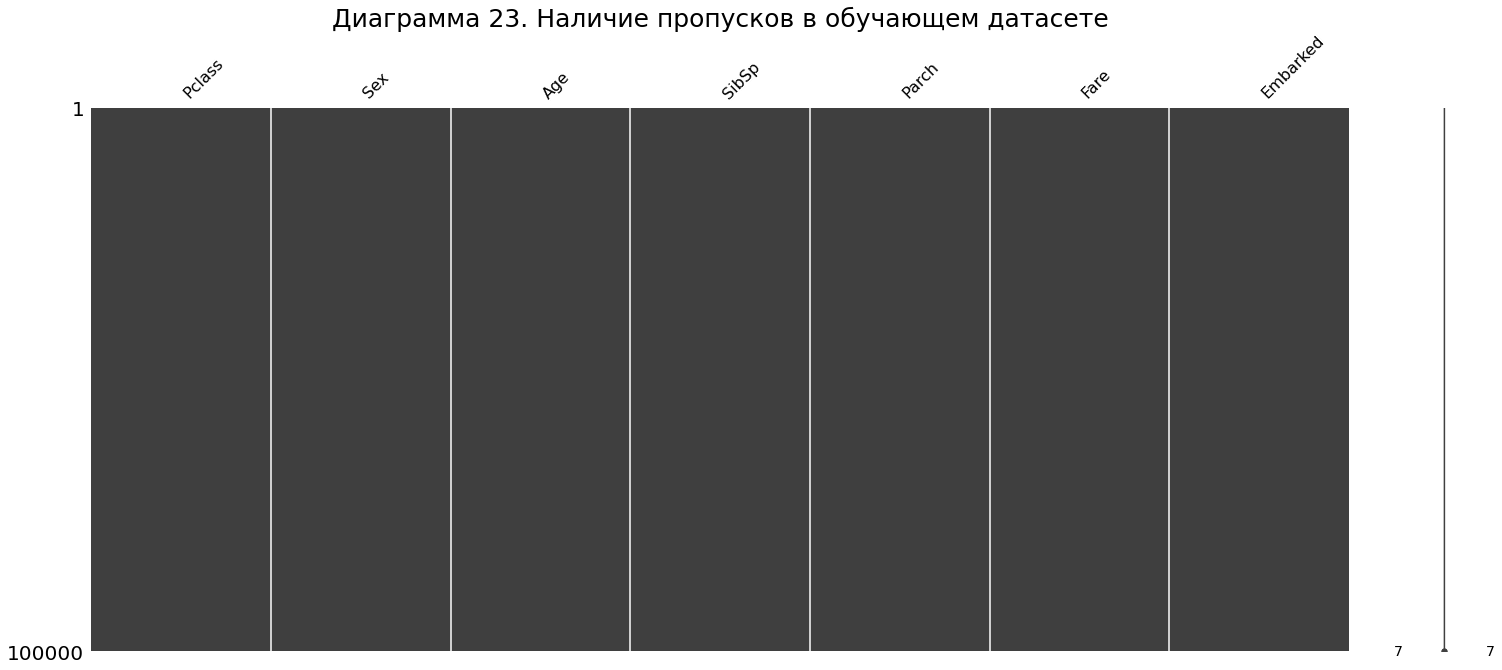

In [73]:
msno.matrix(X_train)
plt.title(title_num("Наличие пропусков в обучающем датасете"), fontsize=25);

In [74]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
0,1,male,38.355472,2,0,27.14,S
1,3,male,38.355472,0,0,13.35,S
2,3,male,0.330000,1,2,71.29,S
3,3,male,19.000000,0,0,13.04,S
4,3,male,25.000000,0,0,7.76,S


In [75]:
X_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [76]:
del X_test["Cabin"]
del X_test["Ticket"]
del X_test["Name"]

X_test["Age"] = X_test["Age"].fillna(n_age_mean)
X_test["Fare"] = X_test["Fare"].fillna(n_fate_mean)
X_test["Embarked"] = X_test["Embarked"].fillna("S")

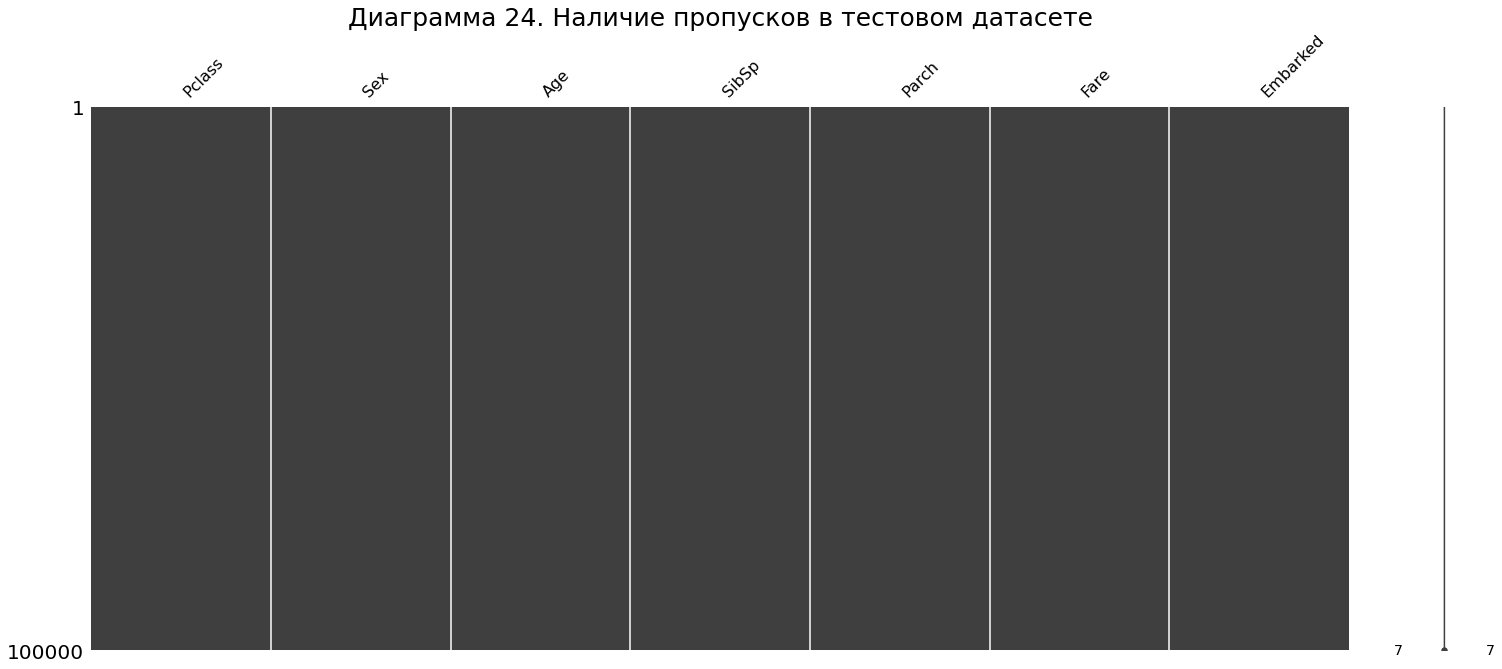

In [77]:
msno.matrix(X_test)
plt.title(title_num("Наличие пропусков в тестовом датасете"), fontsize=25);

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

*****
### `КОММЕНТАРИЙ`

>При выполнении одинаковых операций с двумя датасетами (особенно при фичаинжениренге) возможна ошибка - можно пропустить операцию в одном из датасетов, но выполнив в другом. Для того что бы не ошибиться объединим их в один, а в нужный момент опять разрежем на два.
*****



In [78]:
df = pd.concat([X_train, X_test], ignore_index=True)
df.shape

(200000, 7)

In [79]:
def split_train_for_test():
    return df.head(100000), df.tail(100000)

# Здесь добавляем фичи

In [80]:
print(df.shape)
df.columns

(200000, 7)


Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [81]:
def age_type(nage, ntype=1):
    if nage == np.nan:
        retrn ("" if ntype==1 else 0)
    ret_value = ""
    for num, element in enumerate(age_types):
        if (nage > element[1]) & (nage <= element[2]):
            return element[0] if ntype == 1 else num + 1

age_types = [
    ["1. Новорождённые", -1, 1], 
    ["2. Дошкольники", 1, 7], 
    ["3. Младшие школьники", 7, 12], 
    ["4. Тинейджеры", 12, 15],
    ["5. Молодые люди", 15, 28],
    ["6. Взрослые люди", 28, 40],
    ["7. Люди от 40 до 60", 40, 60],
    ["8. Пожилые", 60, 200],
           ]

df["int_age"] = df["Age"].apply(lambda y: int(y))

In [82]:
df["alone"] = df[["SibSp", "Parch"]].apply(lambda data: min(1, data.SibSp + data.Parch), axis=1)
df["2classes"] = df["Pclass"].apply(lambda data: 1 if data < 3 else 3)
df["2ports"] = df["Embarked"].apply(lambda data: 1 if data =="S" else 0)
df["nSex"] = df["Sex"].apply(lambda data: 1 if data =="male" else 0)
df["family_size"] = df[["SibSp", "Parch"]].apply(lambda data: data.SibSp + data.Parch, axis=1)


In [83]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,int_age,alone,2classes,2ports,nSex,family_size
0,1,male,38.355472,2,0,27.14,S,38,1,1,1,1,2
1,3,male,38.355472,0,0,13.35,S,38,0,3,1,1,0
2,3,male,0.330000,1,2,71.29,S,0,1,3,1,1,3
3,3,male,19.000000,0,0,13.04,S,19,0,3,1,1,0
4,3,male,25.000000,0,0,7.76,S,25,0,3,1,1,0


In [84]:
# categ_list = ["Pclass", "Sex", "SibSp", "Parch", 'Embarked', "age_ntype", "alone"]
# drop_list = ["Pclass", "Sex", 'Embarked', "age_ntype", "alone"]
categ_list = ["Pclass", "Sex", "SibSp", "Parch", 'Embarked', "alone"]
drop_list = ["Pclass", "Sex", 'Embarked', "alone"]


In [85]:
# -------------------------------
ohe = OneHotEncoder(sparse=False)
ohe.fit(df[categ_list])
df[ohe.get_feature_names_out()] = ohe.transform(df[categ_list])
# -------------------------------

print(df.shape)
df.columns

(200000, 38)


Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'int_age',
       'alone', '2classes', '2ports', 'nSex', 'family_size', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Parch_9', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'alone_0',
       'alone_1'],
      dtype='object')

In [86]:
df.drop(columns=drop_list, axis=1, inplace=True)
print(df.shape)
df.columns

(200000, 34)


Index(['Age', 'SibSp', 'Parch', 'Fare', 'int_age', '2classes', '2ports',
       'nSex', 'family_size', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4',
       'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
       'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'alone_0', 'alone_1'],
      dtype='object')

In [87]:
df.head()

,Age,SibSp,Parch,Fare,int_age,2classes,2ports,nSex,family_size,Pclass_1,...,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S,alone_0,alone_1
0,38.355472,2,0,27.14,38,1,1,1,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,38.355472,0,0,13.35,38,3,1,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.330000,1,2,71.29,0,3,1,1,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,19.000000,0,0,13.04,19,3,1,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,25.000000,0,0,7.76,25,3,1,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [88]:
tmp_X_train, tmp_X_test = split_train_for_test()

### LogisticRegression

In [89]:
model = LogisticRegression(max_iter=1000, random_state = 42)

scores = cross_validate(model, tmp_X_train, Y, cv=5)
print(scores['test_score'])

[0.76805 0.76455 0.76925 0.76625 0.76565]


### KNN

In [90]:
model = KNeighborsClassifier(n_neighbors=3, weights='distance')

scores = cross_validate(model, tmp_X_train, Y, cv=5)
print(scores['test_score'])

[0.7031  0.70035 0.7014  0.6981  0.6985 ]


*****
### `КОММЕНТАРИЙ`

>Видно, что результаты разные: у KNN скор хуже чем у LR (при тех исходных параметрах, которые были выбраны) и KNN работает значительно дольше.
*****



**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [91]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file='_submission.csv',
                             target='Survived', index_label="PassengerId"):

    global nsaves_counter
    nsaves_counter += 1
    first_idx = 100_000
    
    out_file = os.path.join(PATH, 'titanic', str(nsaves_counter).zfill(3) + out_file)
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(first_idx, predicted_labels.shape[0] + first_idx),
                                columns=[target])

    predicted_df.to_csv(out_file, index_label=index_label)

In [92]:
model = LogisticRegression(max_iter=1000, random_state = 42)
model.fit(tmp_X_train, Y)
Y_predicted = model.predict(tmp_X_test)

In [93]:
write_to_submission_file(Y_predicted)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

# НЕ УСПЕЛ.  ОДНОГО ДНЯ НА СОРЕВНОВАНИЕ МАЛО.